# EDA: CTR Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

Let us start by exploring the underlying distribution and characteristics of each of our features.
In order to do so, we will first load and process the dataset, mainly, we will omit fully empty rows, deduplicate the data, and convert the "DateTime" variable to datetime type.
Then, we will produce some summary statistics in order to get a feel of the data and its behaviour, and then visualize it for better understanding.

Given the nature of the data, we will produce different summary statistics for the different data types: continuous variables will be presented with mean, median, std, outliers etc. whereas categorical variables (including numeric ones) will be presented using frequency distribution information and mode.

In [2]:
# load the data
filepath = "train_dataset_full.csv"
df = pd.read_csv(filepath)

initial_shape = df.shape  # save the initial size of the data

# remove entirely empty rows and fully duplicate rows
df = df.dropna(how="all").drop_duplicates()
rows_after_cleaning = df.shape[0]  # save the shape upon modification

# ensure the DateTime column is in datetime format
df["DateTime"] = pd.to_datetime(df["DateTime"])

# ensure values that are supposed to be ints are indeed so (and not unnecessarily floats)
int_columns = ['campaign_id', 'webpage_id', 'product_category_1',
               'age_level', 'user_depth', 'city_development_index']
for col in int_columns:
    df[col] = df[col].apply(lambda x: int(x) if pd.notnull(x) else x)

# define the categories of the variables, in order to place them in the relevant summary table
categorical_columns = [
    'product', 'campaign_id', 'webpage_id', 'product_category_1',
    'gender', 'age_level', 'user_depth', 'city_development_index'
]
id_columns = ['session_id', 'user_id']
continuous_columns = [col for col in df.columns if col not in categorical_columns + id_columns]


print("Data Cleaning Summary:")
print(f"Number of Columns: {initial_shape[1]:,}")
print(f"Initial number of rows: {initial_shape[0]:,}")
print(f"Number of rows after empty row removal and deduplication: {rows_after_cleaning:,}")
print(f"Total rows removed: {initial_shape[0] - rows_after_cleaning:,}")

Data Cleaning Summary:
Number of Columns: 15
Initial number of rows: 389,163
Number of rows after empty row removal and deduplication: 369,652
Total rows removed: 19,511


In [3]:
# produce a summary of the variables in the dataset:
# separate summaries for categorical and continuous variables
categorical_summary, continuous_summary = [], []

for column in df.columns:
    dtype = df[column].dtype
    missing = df[column].isnull().sum()  # amount of nulls
    missing_pct = (missing / len(df)) * 100  # % of nulls
    unique_values = df[column].nunique()

    # base metrics for all columns
    base_metrics = {
        "Variable": column,
        "Type": str(dtype),
        "Number of Missing": missing,
        "% of Missing": f"{missing_pct:.2f}%",
        "Unique Values": unique_values,
    }

    if column in categorical_columns or column in id_columns:
        # for categorical variables, include frequency distribution and mode
        value_counts = df[column].value_counts()
        mode_value = value_counts.index[0] if not value_counts.empty else None
        mode_freq = value_counts.iloc[0] if not value_counts.empty else 0
        value_dist = ', '.join([f"{v}({c})" for v, c in value_counts.nlargest(5).items()])

        # Calculate CTR per category if the column is categorical (not ID)
        if column in categorical_columns and 'is_click' in df.columns:
            ctr_by_category = df.groupby(column)['is_click'].mean() * 100
            ctr_stats = f"Min CTR: {ctr_by_category.min():.2f}%, Max CTR: {ctr_by_category.max():.2f}%"
        else:
            ctr_stats = "N/A"

        categorical_metrics = {
            **base_metrics,
            "Mode": mode_value,
            "Mode Frequency": f"{(mode_freq/len(df))*100:.2f}%",
            "Top Values Distribution": value_dist,
            "CTR Range": ctr_stats if column in categorical_columns else "N/A"
        }
        categorical_summary.append(categorical_metrics)

    else:
        # for continuous variables, include standard statistical measures
        non_null = df[column].dropna()
        if pd.api.types.is_numeric_dtype(df[column]):
            Q1, Q3 = non_null.quantile(0.25), non_null.quantile(0.75)
            IQR = Q3 - Q1
            outlier_count = len(non_null[(non_null < (Q1 - 1.5 * IQR)) | (non_null > (Q3 + 1.5 * IQR))])

            continuous_metrics = {
                **base_metrics,
                "Mean": f"{non_null.mean():.2f}",
                "Median": f"{non_null.median():.2f}",
                "Std": f"{non_null.std():.2f}",
                "Range": f"{non_null.min():.2f} to {non_null.max():.2f}",
                "Outliers": outlier_count,
                "Outliers %": f"{(outlier_count/len(non_null))*100:.2f}%"
            }
            continuous_summary.append(continuous_metrics)


# create and display the two summary tables
print("\nCategorical Variables Summary:")
categorical_df = pd.DataFrame(categorical_summary)
display(HTML(categorical_df.to_html()))

print("\nContinuous Variables Summary:")
continuous_df = pd.DataFrame(continuous_summary)
display(HTML(continuous_df.to_html()))


Categorical Variables Summary:


,Variable,Type,Number of Missing,% of Missing,Unique Values,Mode,Mode Frequency,Top Values Distribution,CTR Range
0,session_id,float64,2971,0.80%,366681,98528.0,0.00%,"98528.0(1), 495126.0(1), 254157.0(1), 445237.0(1), 459109.0(1)",N/A
1,user_id,float64,2926,0.79%,133893,658554.0,0.06%,"658554.0(207), 297960.0(172), 983136.0(156), 422201.0(121), 18434.0(115)",N/A
2,product,object,3024,0.82%,10,C,35.05%,"C(129563), H(86524), I(50365), D(32438), B(17758)","Min CTR: 4.59%, Max CTR: 9.38%"
3,campaign_id,float64,3054,0.83%,10,359520.0,23.12%,"359520.0(85471), 405490.0(76036), 360936.0(41119), 118601.0(28053), 98970.0(27696)","Min CTR: 4.50%, Max CTR: 9.14%"
4,webpage_id,float64,3018,0.82%,9,13787.0,34.24%,"13787.0(126584), 60305.0(76038), 28529.0(28055), 6970.0(27700), 45962.0(23255)","Min CTR: 5.31%, Max CTR: 9.13%"
5,product_category_1,float64,3046,0.82%,5,4.0,28.51%,"4.0(105387), 3.0(89974), 1.0(64285), 2.0(54802), 5.0(52158)","Min CTR: 5.86%, Max CTR: 8.38%"
6,gender,object,17463,4.72%,2,Male,84.18%,"Male(311183), Female(41006)","Min CTR: 6.44%, Max CTR: 6.81%"
7,age_level,float64,17409,4.71%,7,3.0,34.36%,"3.0(127023), 2.0(113584), 4.0(50555), 1.0(34310), 5.0(24416)","Min CTR: 5.85%, Max CTR: 10.57%"
8,user_depth,float64,17454,4.72%,3,3.0,86.22%,"3.0(318706), 2.0(24083), 1.0(9409)","Min CTR: 6.42%, Max CTR: 7.25%"
9,city_development_index,float64,102035,27.60%,4,2.0,31.62%,"2.0(116898), 3.0(70237), 4.0(53138), 1.0(27344)","Min CTR: 6.48%, Max CTR: 7.03%"



Continuous Variables Summary:


,Variable,Type,Number of Missing,% of Missing,Unique Values,Mean,Median,Std,Range,Outliers,Outliers %
0,product_category_2,float64,292615,79.16%,28,162819.25,146115.00,78690.58,18595.00 to 450184.00,0,0.00%
1,user_group_id,float64,17422,4.71%,13,3.48,3.00,2.42,0.00 to 12.00,39859,11.32%
2,var_1,float64,3033,0.82%,2,0.42,0.00,0.49,0.00 to 1.00,0,0.00%
3,is_click,float64,3018,0.82%,2,0.07,0.00,0.25,0.00 to 1.00,24812,6.77%


Looking at the above summary statistics, we can notice a few things:
* Some variables have a substantive, non-negligible, amount of null values: mainly, "product_category_1" (nearly 80%), "city_development_index" (nearly 28%). We might need to decide how to complete the data, or how to treat it with caution in case we keep it with the null values.
* Some variables seem to behave like categorical, although they have an id-like name. This can be seen due to the low number of unique values they hold: "campaign_id", "webpage_id", "user_group_id". We will treat them accordingly- as if they represent categories.
    * The only actual id variables are "session_id" and "user_id".
* The "gender" variable's distribution shows significant imbalance, with strong male dominance (84.18% mode frequency).
    * Although this imbalance is significant, when looking at the CTR patterns of both groups: they have a small variation, meaning gender isn't a strong predictor of click behavior.
* Similarly, there is a significant imbalance in the user engagement levels ("user_depth"), where 86.22% of users are at level 3.0. This seemingly suggests a mature user base with high engagement (if assumed that a higher level is higher, or more sophisticated engagement behavior).
    * Interestingly, here too, the imbalance does not seem to affect the CTR variance, and therefore too isn't a strong predictor of click behavior.
* Lastly, age levels show the widest CTR range (5.85% to 10.57%), which may suggest this is a good predictor of click behavior.

Next up, we will visualize the distribution of the continuous and categorical variables, and time-series plots for the temporal ones.


USER BEHAVIOR ANALYSIS


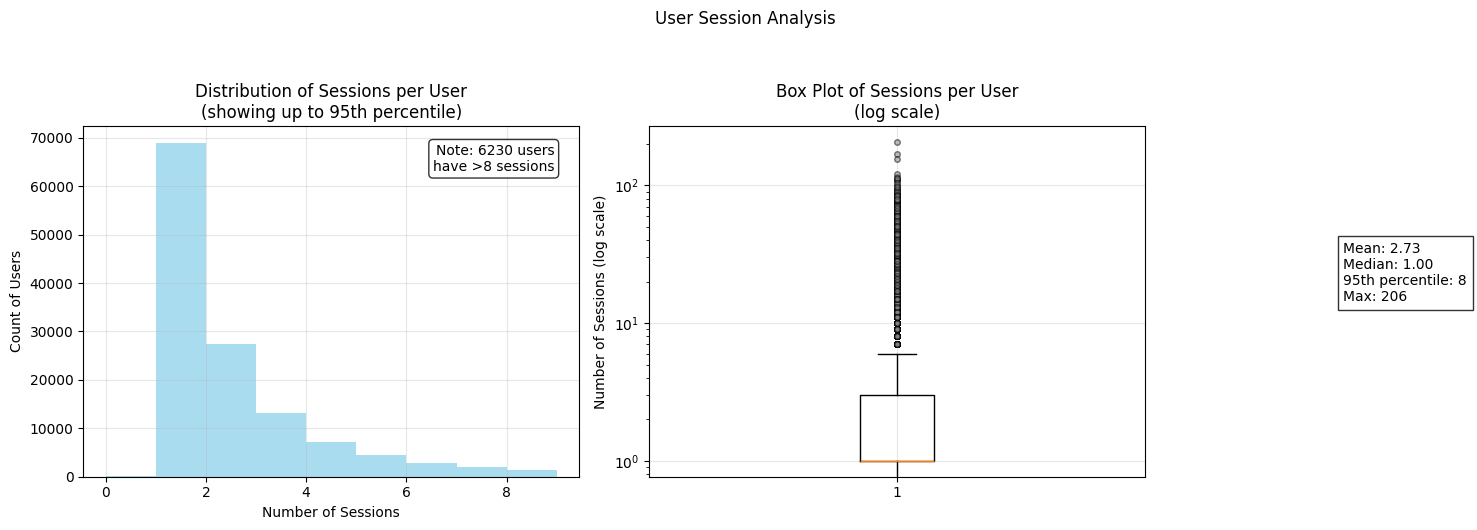


CATEGORICAL VARIABLE ANALYSIS


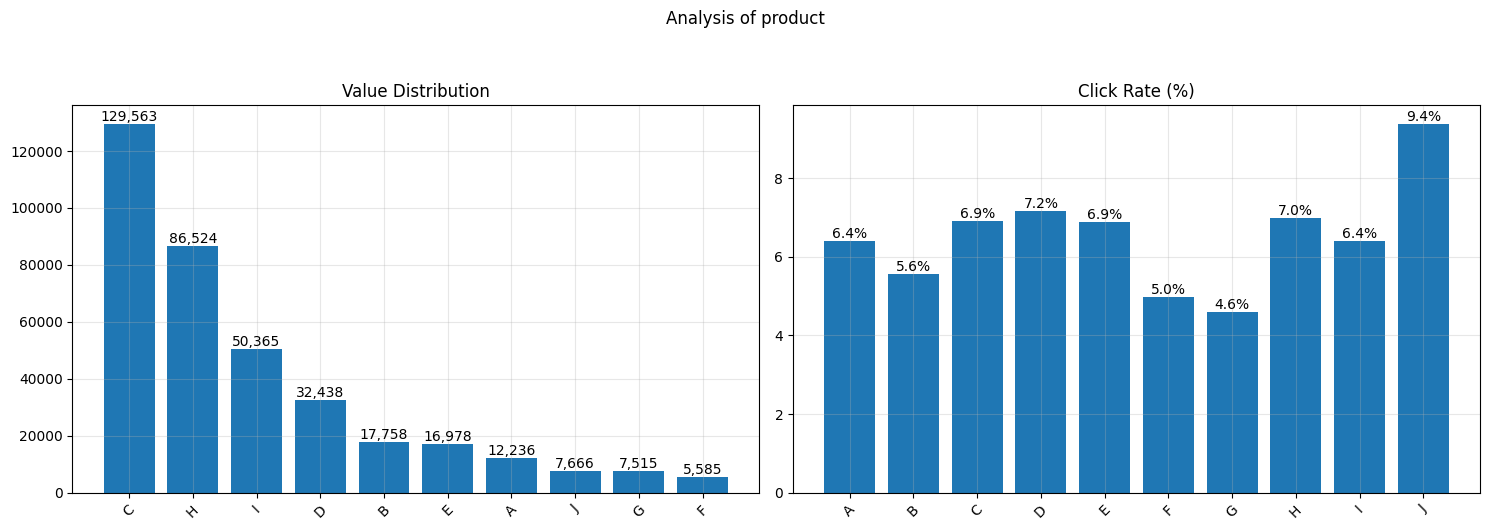

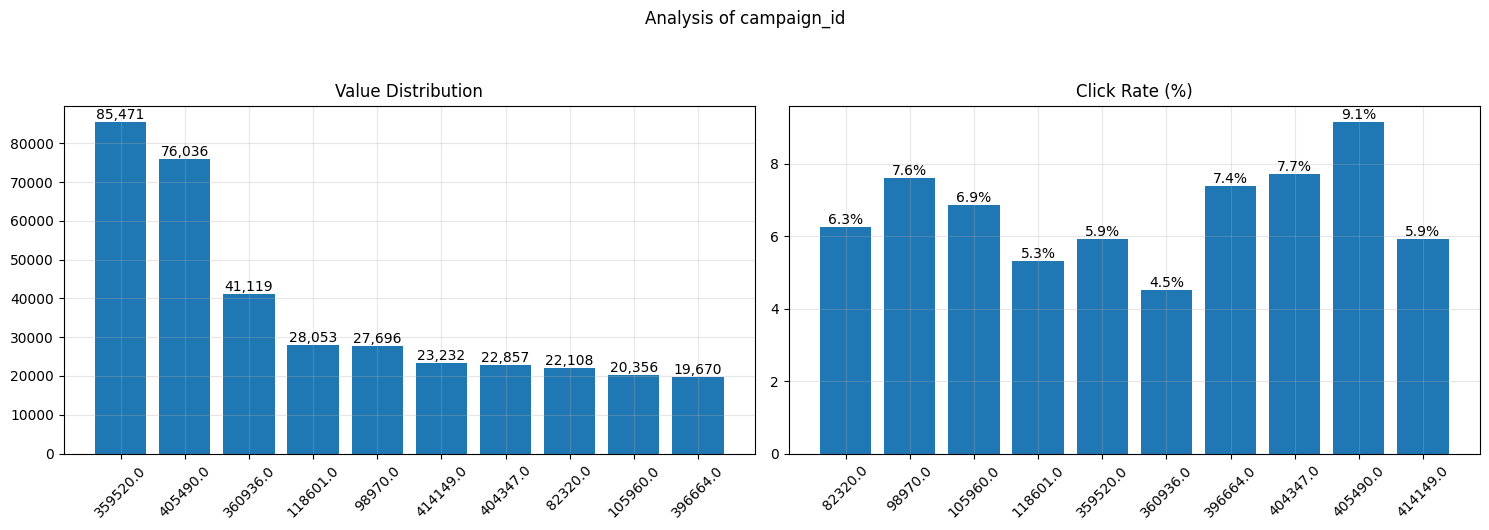

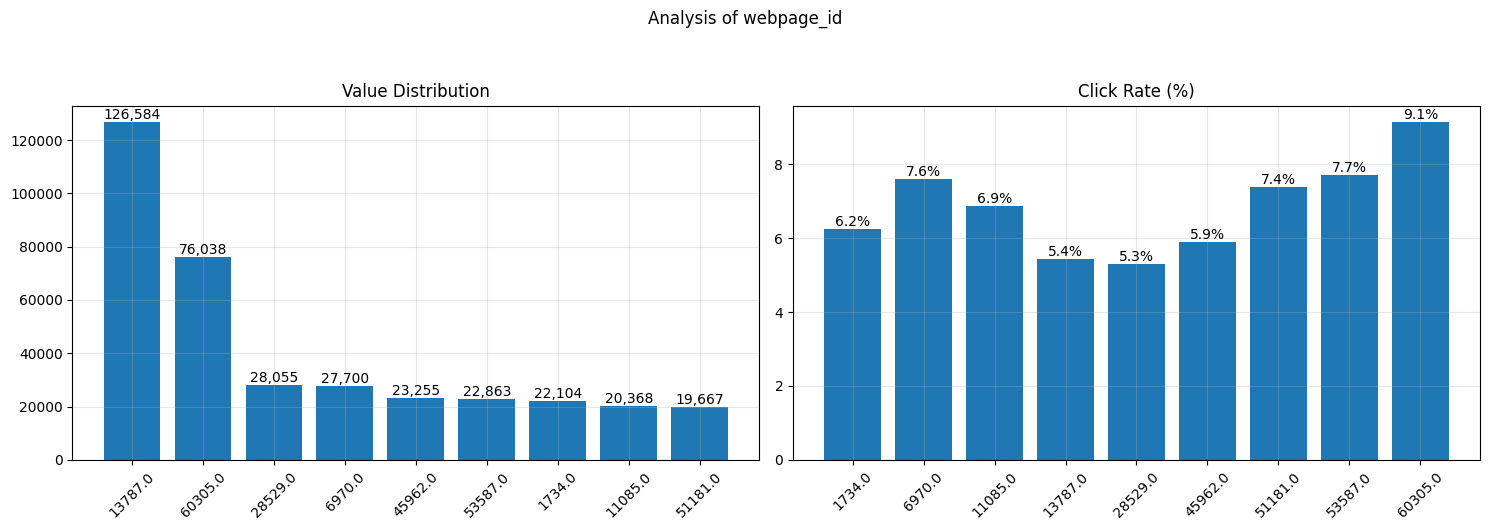

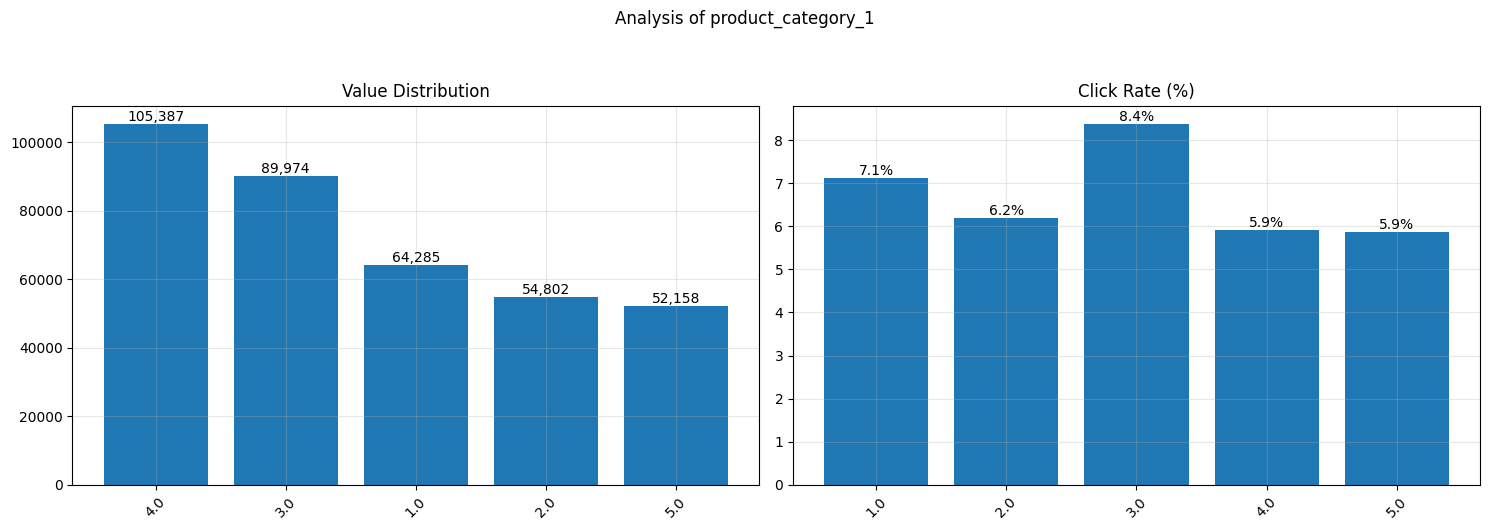

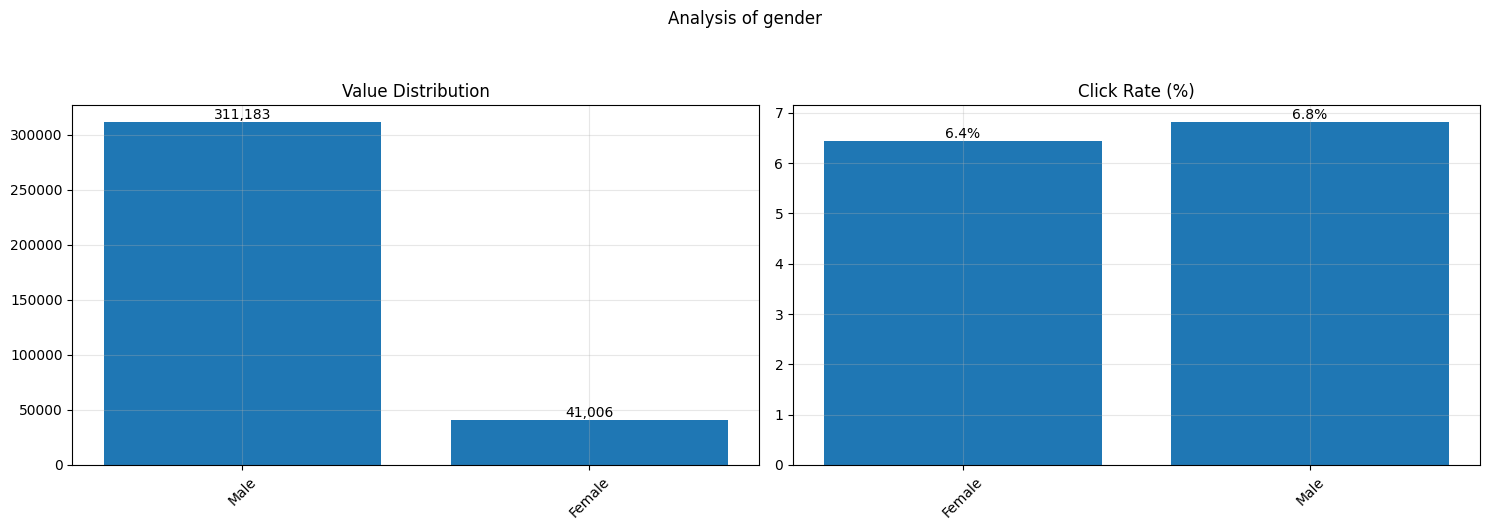

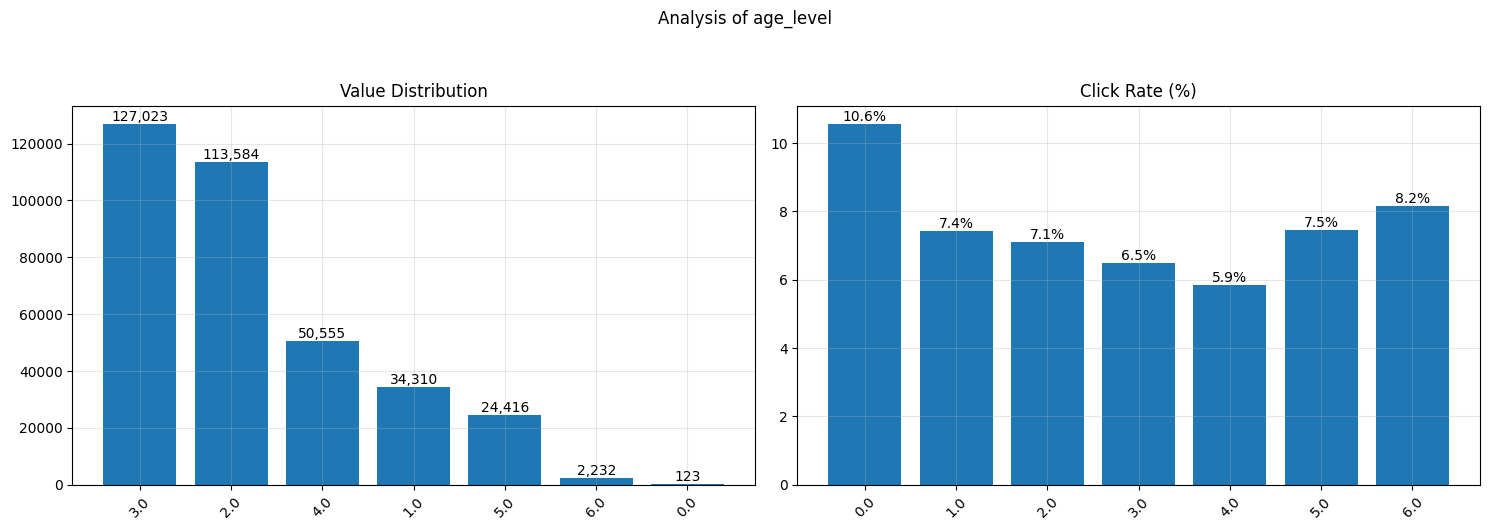

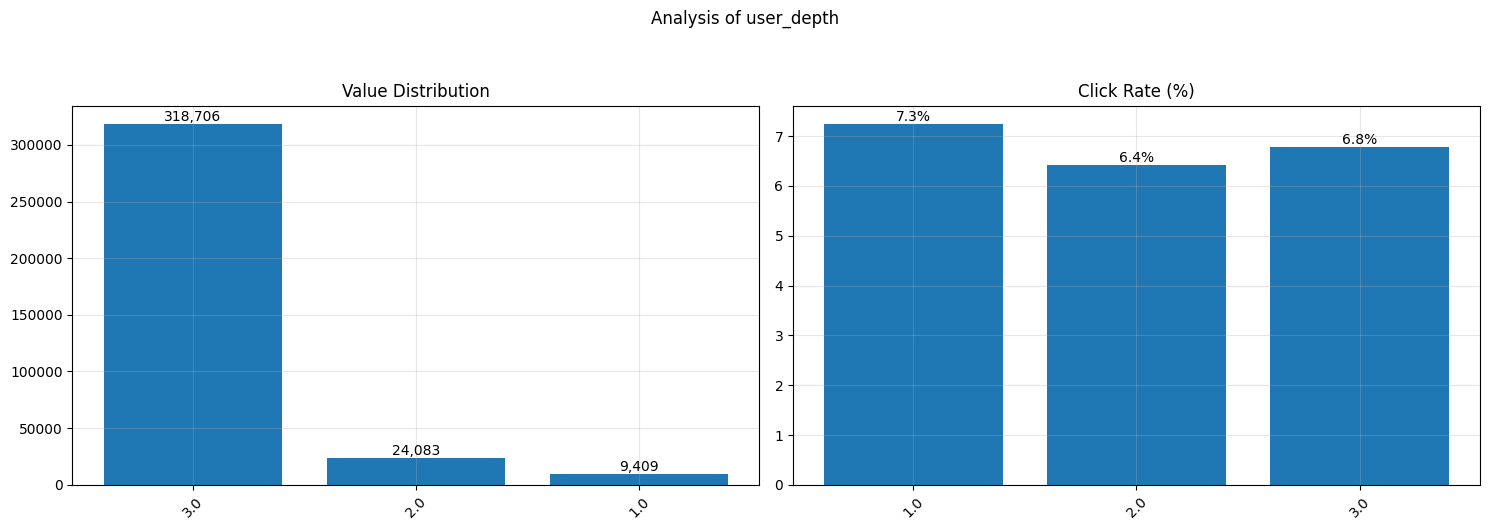

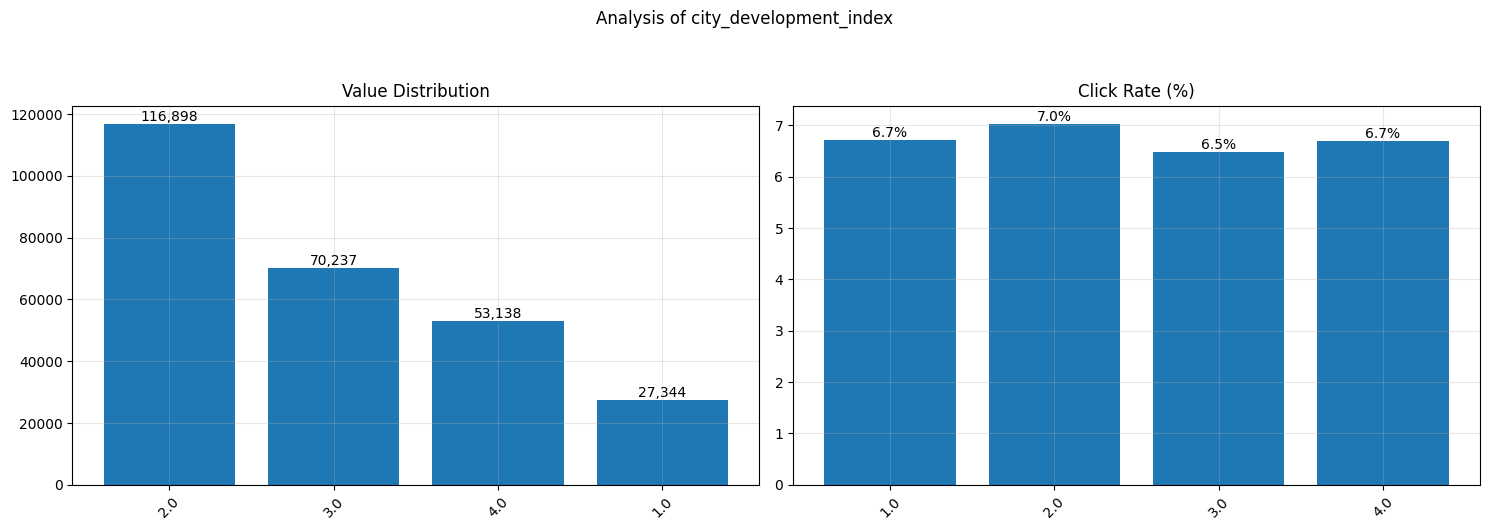


TEMPORAL ANALYSIS


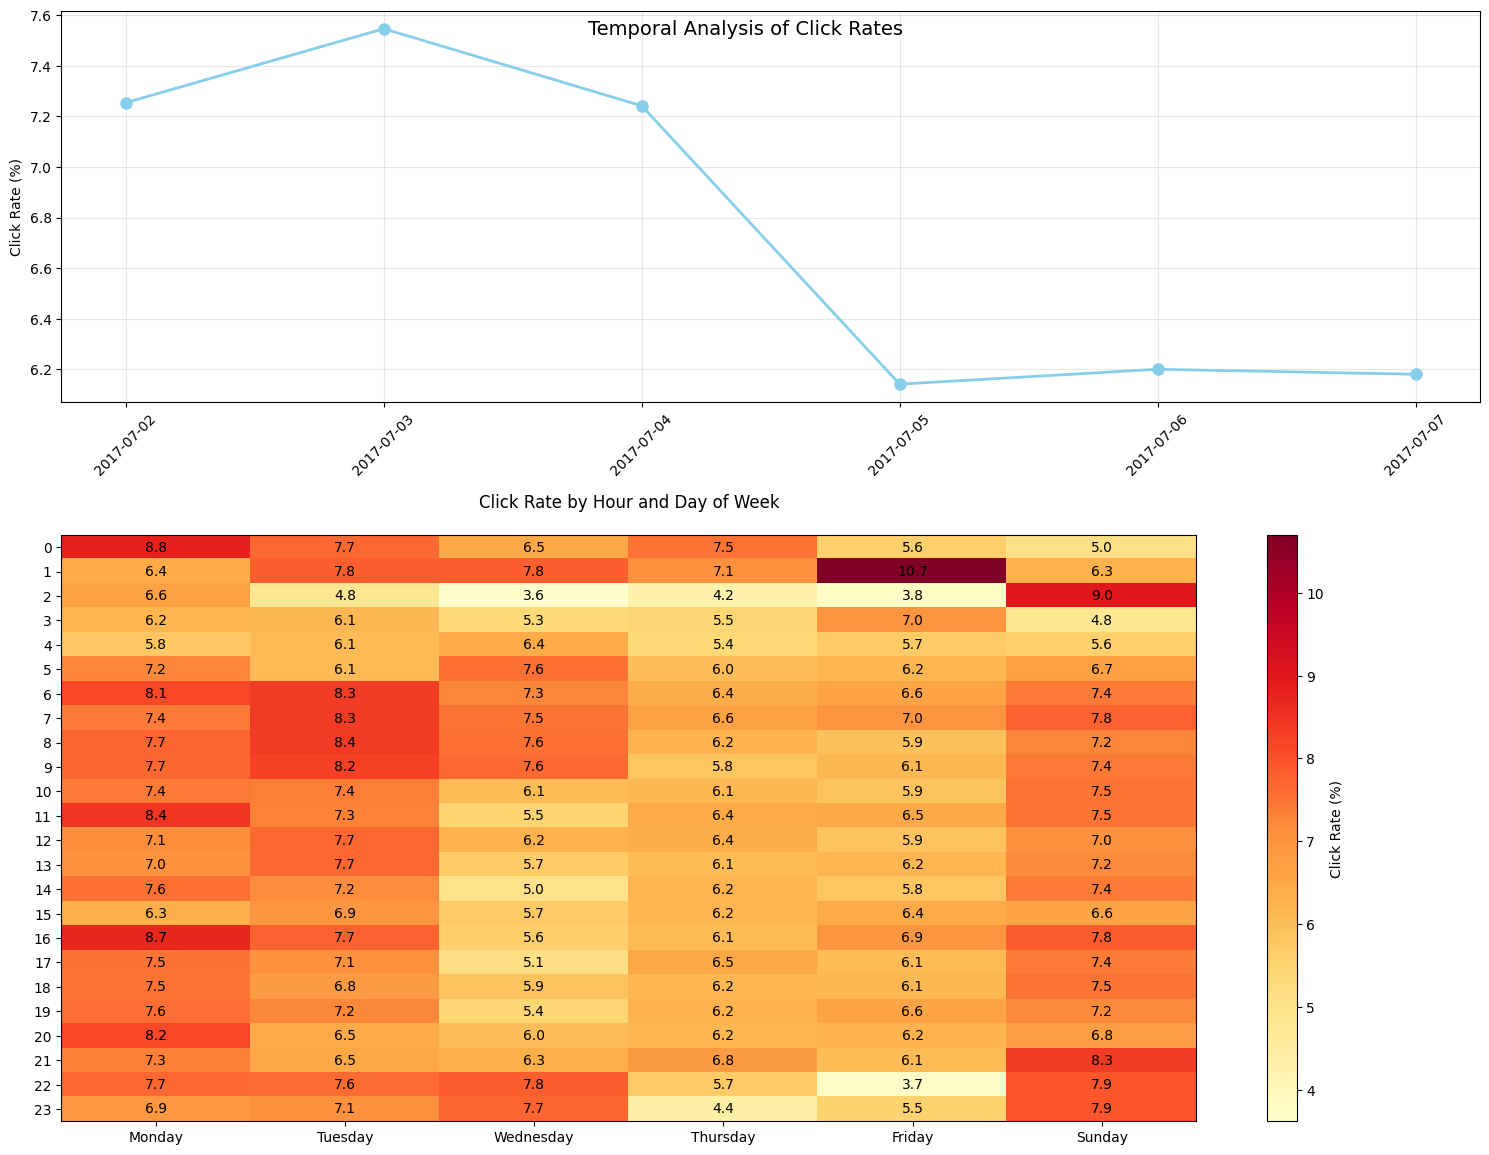

In [4]:
def plot_user_sessions(user_sessions):
    """
    Plot distribution of sessions per user with better outlier handling
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Get statistics for text box
    stats_text = f"Mean: {user_sessions['session_count'].mean():.2f}\n"
    stats_text += f"Median: {user_sessions['session_count'].median():.2f}\n"
    stats_text += f"95th percentile: {user_sessions['session_count'].quantile(0.95):.0f}\n"
    stats_text += f"Max: {user_sessions['session_count'].max():.0f}"

    # Distribution plot (histogram)
    # Plot main distribution (up to 95th percentile)
    p95 = user_sessions['session_count'].quantile(0.95)
    main_dist = user_sessions[user_sessions['session_count'] <= p95]

    # Calculate bins
    bins = np.arange(0, main_dist['session_count'].max() + 2, 1)

    ax1.hist(main_dist['session_count'], bins=bins, alpha=0.7, color='skyblue')
    ax1.set_title('Distribution of Sessions per User\n(showing up to 95th percentile)')
    ax1.set_xlabel('Number of Sessions')
    ax1.set_ylabel('Count of Users')
    ax1.grid(True, alpha=0.3)

    # Add text about outliers
    outliers_text = f"Note: {len(user_sessions[user_sessions['session_count'] > p95])} users"
    outliers_text += f"\nhave >{p95:.0f} sessions"
    ax1.text(0.95, 0.95, outliers_text, transform=ax1.transAxes,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Box plot with adjusted whiskers
    bp = ax2.boxplot(user_sessions['session_count'],
                    whis=1.5,  # Standard 1.5 IQR for whiskers
                    showfliers=True,  # Show outliers
                    flierprops=dict(marker='o', markerfacecolor='gray',
                                  markersize=4, alpha=0.5))

    ax2.set_yscale('log')  # Use log scale for better visualization
    ax2.set_title('Box Plot of Sessions per User\n(log scale)')
    ax2.set_ylabel('Number of Sessions (log scale)')
    ax2.grid(True, alpha=0.3)

    # Add stats text
    ax2.text(1.4, 0.5, stats_text, transform=ax2.transAxes,
             bbox=dict(facecolor='white', alpha=0.8))

    plt.suptitle('User Session Analysis', y=1.05)
    plt.tight_layout()

    return fig


def plot_categorical_variable(clean_df, col, target='is_click'):
    """
    Create a subplot with value distribution and relationship with target variable
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Value distribution
    value_counts = clean_df[col].value_counts()
    bars1 = ax1.bar(range(len(value_counts)), value_counts.values)

    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom')

    ax1.set_title('Value Distribution')
    ax1.set_xticks(range(len(value_counts)))
    ax1.set_xticklabels(value_counts.index, rotation=45)
    ax1.grid(True, alpha=0.3)

    # Relationship with target
    cross_tab = pd.crosstab(clean_df[col], clean_df[target], normalize='index') * 100
    bars2 = ax2.bar(range(len(cross_tab)), cross_tab[1])

    # Add percentage labels
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom')

    ax2.set_title('Click Rate (%)')
    ax2.set_xticks(range(len(cross_tab)))
    ax2.set_xticklabels(cross_tab.index, rotation=45)
    ax2.grid(True, alpha=0.3)

    plt.suptitle(f'Analysis of {col}', y=1.05)
    plt.tight_layout()

    return fig


def plot_temporal_analysis(clean_df):
    """
    Create temporal analysis plots with improved styling and robust day handling
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), height_ratios=[1, 1.5])

    # generate a time series of the click rate, across days
    daily_clicks = clean_df.groupby(clean_df['DateTime'].dt.date)['is_click'].agg(['count', 'sum'])
    daily_clicks['rate'] = daily_clicks['sum'] / daily_clicks['count'] * 100

    ax1.plot(daily_clicks.index, daily_clicks['rate'], 'o-',
             color='skyblue', linewidth=2, markersize=8)
    ax1.set_ylabel('Click Rate (%)')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)

    # Heatmap of clicks by hour and day
    clean_df['hour'] = clean_df['DateTime'].dt.hour
    clean_df['day'] = clean_df['DateTime'].dt.day_name()

    # Get available days and prepare day mapping
    available_days = clean_df['day'].unique()
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    available_day_order = [day for day in day_order if day in available_days]

    # Create heatmap data
    heatmap_data = pd.pivot_table(
        clean_df, values='is_click',
        index='hour', columns='day',
        aggfunc='mean'
    ) * 100

    # Reorder columns based on available days
    heatmap_data = heatmap_data[available_day_order]

    # Create heatmap
    im = ax2.imshow(heatmap_data, aspect='auto', cmap='YlOrRd')

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax2)
    cbar.set_label('Click Rate (%)')

    # Customize heatmap
    ax2.set_xticks(range(len(available_day_order)))
    ax2.set_xticklabels(available_day_order)
    ax2.set_yticks(range(24))
    ax2.set_yticklabels(range(24))

    # Add text annotations
    for i in range(24):
        for j in range(len(available_day_order)):
            text = ax2.text(j, i, f'{heatmap_data.iloc[i, j]:.1f}',
                          ha="center", va="center", color="black")

    ax2.set_title('Click Rate by Hour and Day of Week', pad=20)

    plt.suptitle('Temporal Analysis of Click Rates', y=0.95, size=14)
    plt.tight_layout()

    return fig



# compute the sessions per user, to make use of our session variables
user_sessions = df.groupby('user_id')['session_id'].count().reset_index()
user_sessions.columns = ['user_id', 'session_count']

categorical_columns = ['product', 'campaign_id', 'webpage_id', 'product_category_1',
                     'gender', 'age_level', 'user_depth', 'city_development_index']

print("\n" + "="*50)
print("USER BEHAVIOR ANALYSIS")
print("="*50)
plot_user_sessions(user_sessions)
plt.show()

print("\n" + "="*50)
print("CATEGORICAL VARIABLE ANALYSIS")
print("="*50)
for col in categorical_columns:
    plot_categorical_variable(df, col)
    plt.show()

print("\n" + "="*50)
print("TEMPORAL ANALYSIS")
print("="*50)
plot_temporal_analysis(df)
plt.show()

Looking at the above visualizations, we can notice that:
* Regarding the user behaviour analysis:
    * The distribution of sessions per user reveals a highly skewed pattern: While most users have just 1-2 sessions, there are various and notable "power users".
    * Interestingly, there are about 6,230 users which have more than 8 sessions, forming a long tail that extends up to 206 sessions for the most active user.
    * This suggests we have a core group of highly engaged users.

* Regarding the categorical variables' analysis:
    * Product "C" dominates with 129,563 impressions but achieves only moderate CTR (6.9%), while Product "I" shows the highest CTR (9.4%) despite its lower volume.
    * The campaign analysis reveals similar insights: campaign ID 359520 has the highest volume (85,471 impressions) but middling performance, while some lower-volume campaigns achieve CTRs above 9%.
    * As we have previously noted:
         * The gender distribution is heavily skewed toward male users (311,183 vs 41,006), but the CTR difference is minimal (6.8% vs 6.4%), suggesting gender may not be a crucial targeting factor.
         * Age levels show more pronounced differences, with level 0.0 achieving the highest CTR (10.6%) and level 4.0 the lowest (5.9%), indicating age could be a more valuable targeting criterion.
         * User depth, representing engagement levels, shows an interesting inverse relationship - while most users (318,706) are at depth 3.0, the highest CTR (7.3%) comes from users at depth 1.0.

* Regarding the temporal data analysis:
    * The daily trend shows a clear decline in CTR from early July (peak of 7.5%) to mid-July (around 6.2%).
        * The american independence day, 4th of July, might have played a role in this user behavior (depending on the product, of course).
    * The heatmap of click rates by hour and day provides particularly valuable insights, where there are two distinct peaks:
         * one at 1:00 AM on Friday (10.7% CTR) and another at 2:00 AM on Sunday (9.0% CTR).
         * These unusual peak times might indicate either international audience engagement or specific user behaviors during these off-hours.
         * Generally, weekday mornings show consistent performance compared to weekends, with a noticeable dip in engagement during typical working hours (10:00 AM - 18:00 PM).

Next, we should explore the correlations between our variables, and how they might interact with our target variable.
We will start by exploring the pearson correlation, across our original features within the dataset.

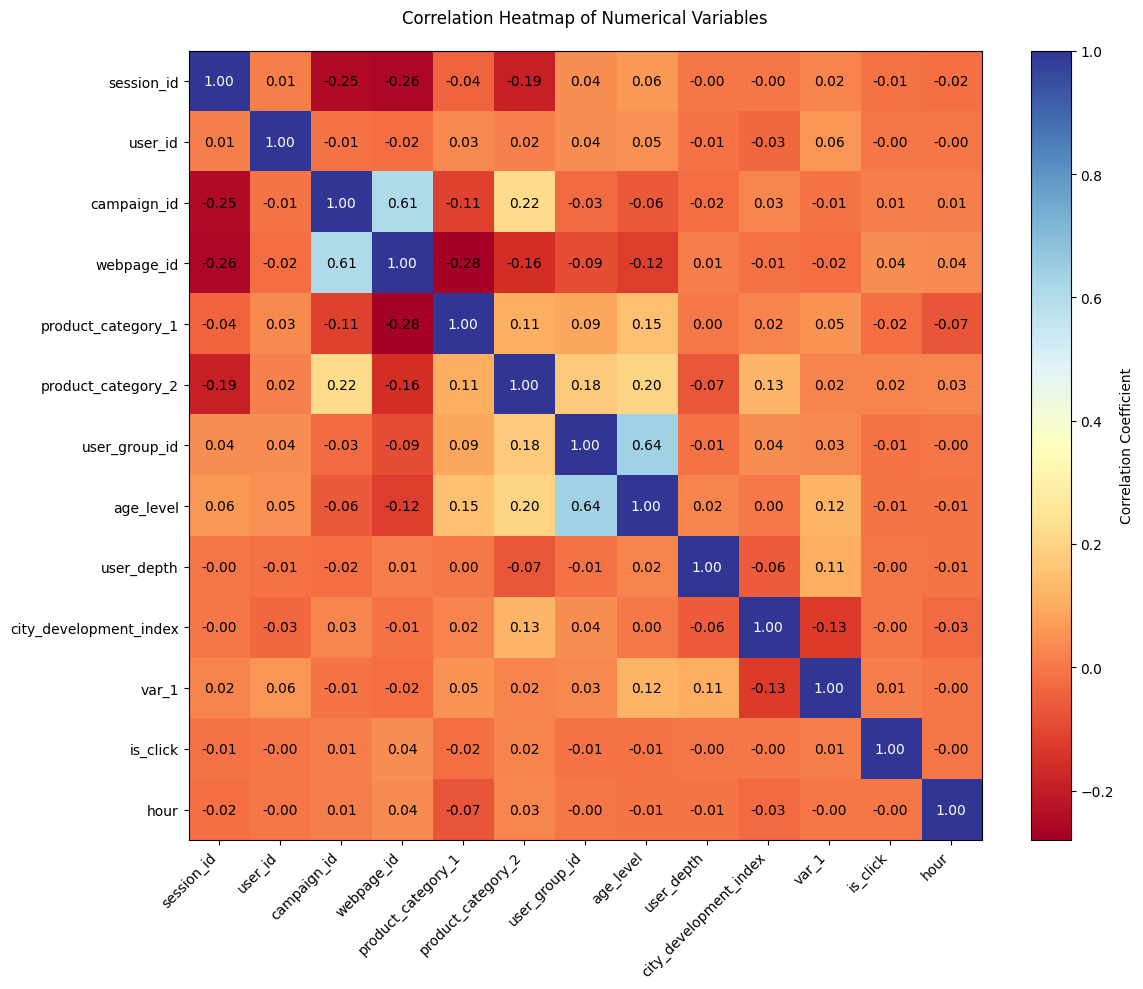

In [5]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = df[numeric_cols].corr()

# create the pearson correlation heatmap
plt.figure(figsize=(12, 10))
im = plt.imshow(corr_matrix, cmap='RdYlBu', aspect='auto')
plt.colorbar(im, label='Correlation Coefficient')
plt.title('Correlation Heatmap of Numerical Variables', pad=20)
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=45, ha='right')
plt.yticks(range(len(numeric_cols)), numeric_cols)

# add the correlation values as text
for i in range(len(numeric_cols)):
    for j in range(len(numeric_cols)):
        text = plt.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                       ha='center', va='center',
                       color='black' if abs(corr_matrix.iloc[i, j]) < 0.7 else 'white')

plt.tight_layout()
plt.show()

Looking at the above heat-map, we can notice that:
* The most striking observation is that none of our existing features show strong correlations with our target variable "is_click", with all correlations falling below 0.05 in absolute value.
* This suggests that linear relationships alone won't be sufficient for predicting click-through rates.
* The strongest structural correlation appears between webpage_id and campaign_id (0.61), which likely reflects intentional campaign design where specific advertisements are consistently placed on certain pages.
* We also observe a meaningful correlation (0.64) between user_group_id and age_level, indicating that user segmentation is partially age-based.
* The subtle correlation (0.18) between user_group_id and product_category_2 might suggest some level of targeted marketing, where certain user segments are more frequently shown specific product categories.
    * However, this relationship is weak enough that it warrants further investigation before drawing strong conclusions.

Given the above, we can try adding new variables, in order to explore patterns in the userbase.
For starters, we can explore how the user demographic and temporal CTRs interact, by

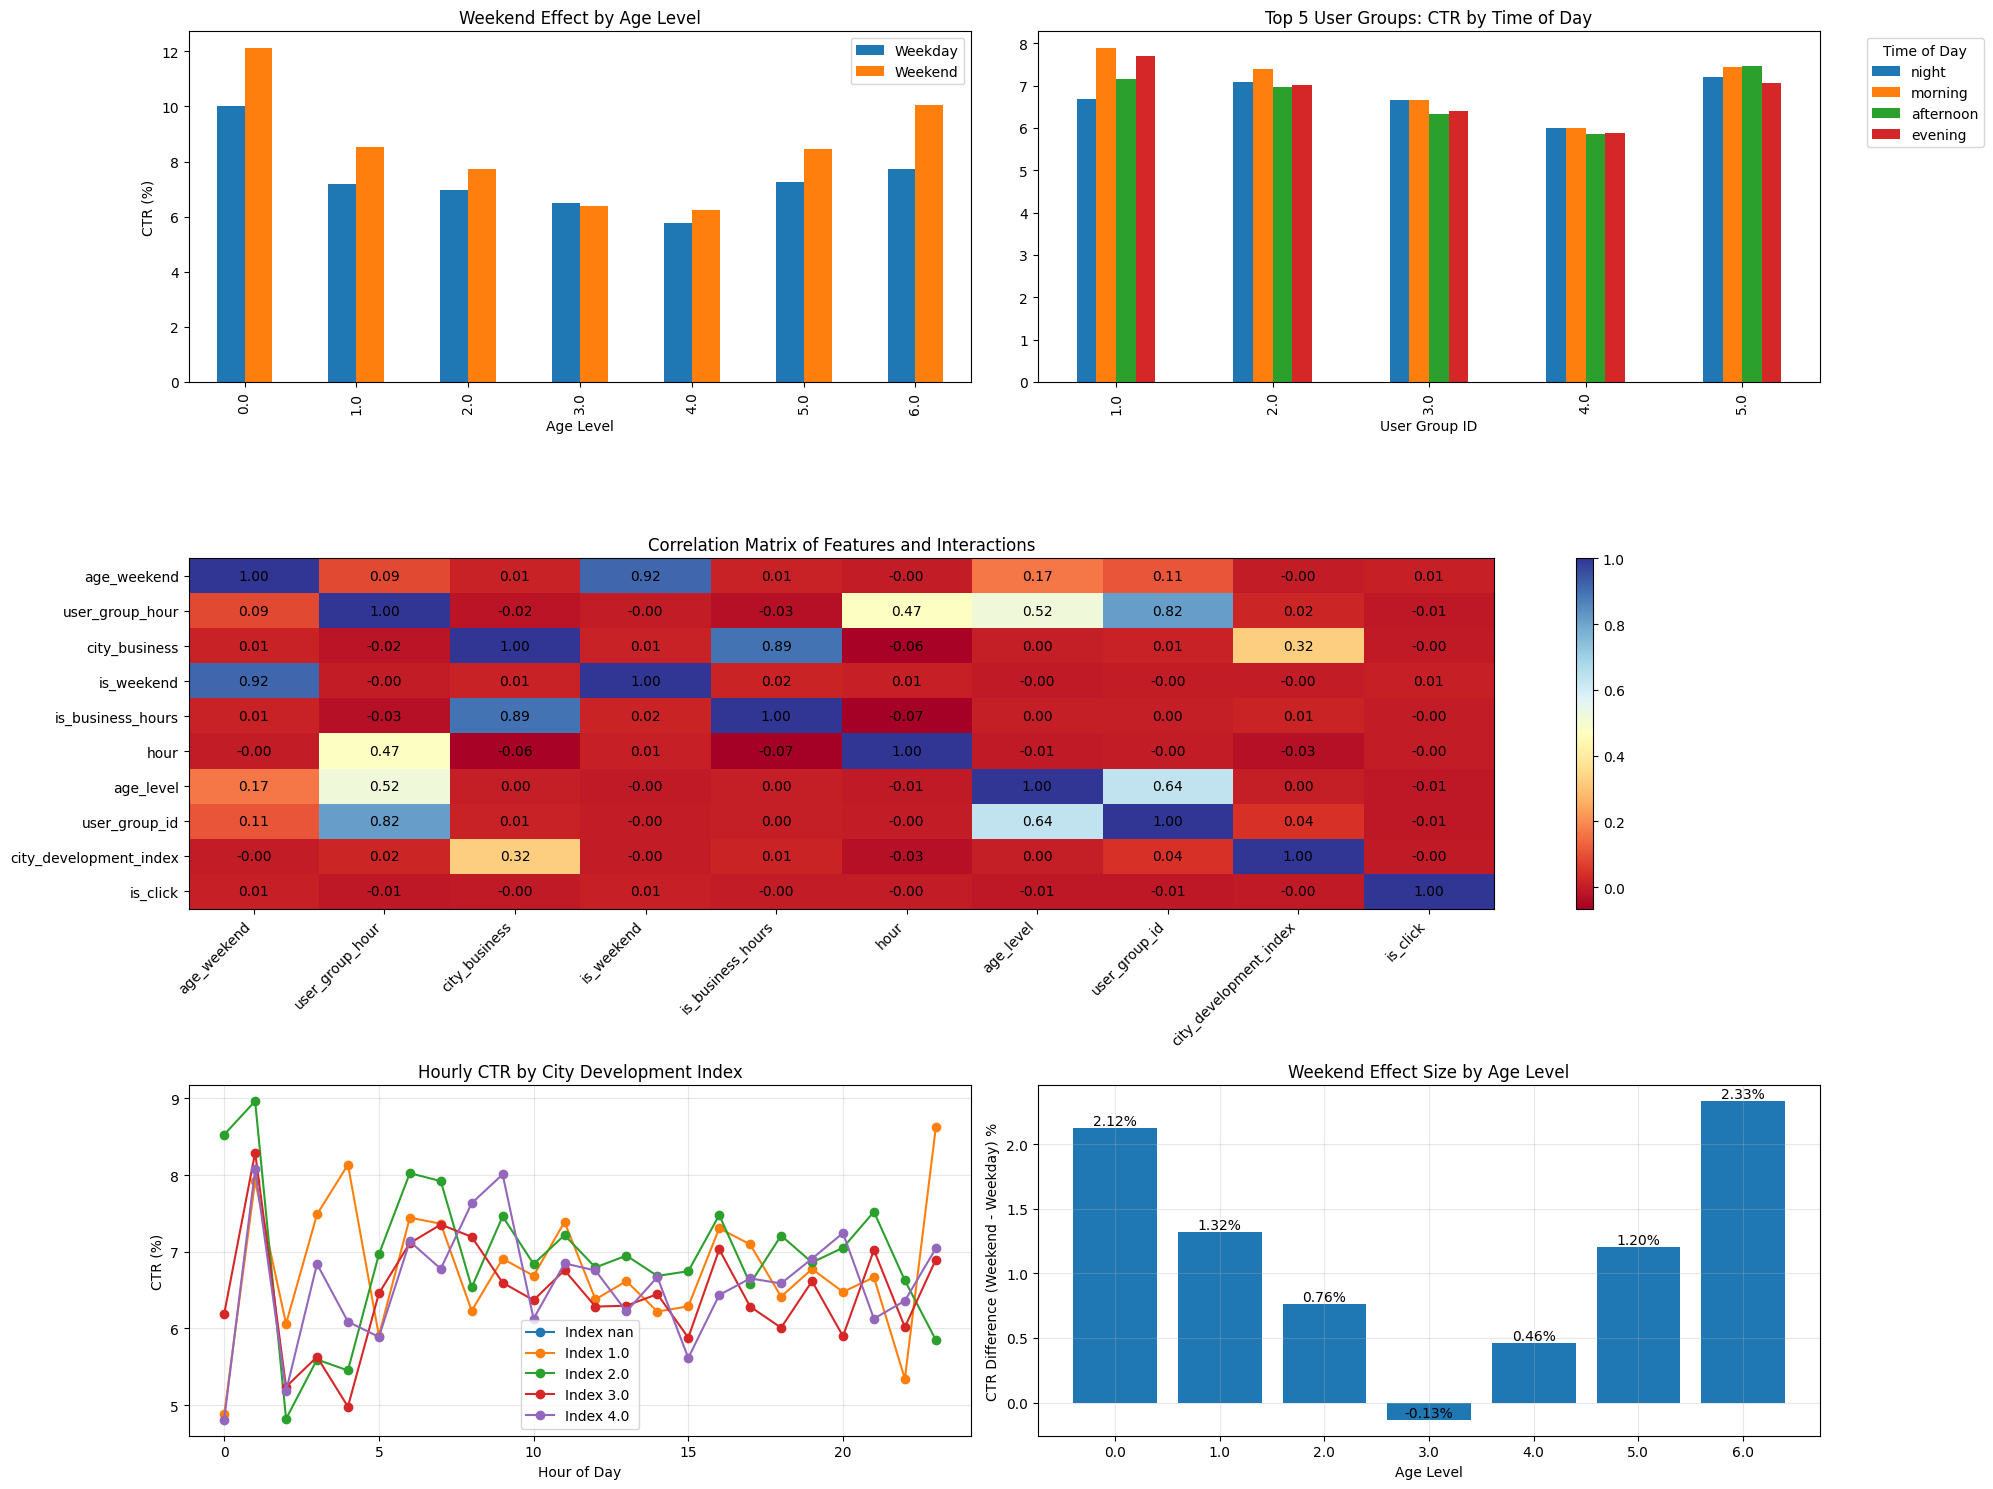

Weekend Effect Analysis:


Age Level,Weekday CTR (%),Weekday Samples,Weekend CTR (%),Weekend Samples,Effect Size (%)
0.0,10.00,90,12.12,33,2.12
1.0,7.19,27930,8.51,6380,1.32
2.0,6.98,94224,7.74,19360,0.76
3.0,6.50,106450,6.37,20573,-0.13
4.0,5.78,42353,6.24,8202,0.46
5.0,7.24,19864,8.45,4552,1.20
6.0,7.71,1793,10.05,439,2.33



Business Hours Impact Analysis:


City Index,Business Hours CTR (%),Non-Business Hours CTR (%),Difference (%),Total Samples
1.0,6.76,6.66,0.10,27344
2.0,6.97,7.09,-0.12,116898
3.0,6.43,6.52,-0.09,70237
4.0,6.60,6.78,-0.19,53138


In [7]:
# adding temporal features:
# hour, time of day (grouping of hour), day, whether it's weekend, whether it's business hours
df['hour'] = df['DateTime'].dt.hour
df['day_of_week'] = df['DateTime'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['is_business_hours'] = df['hour'].between(9, 17).astype(int)
df['time_of_day'] = pd.cut(
    df['hour'],
    bins=[-np.inf, 6, 12, 18, np.inf],
    labels=['night', 'morning', 'afternoon', 'evening']
)

# adding interaction features
df['age_weekend'] = df['age_level'] * df['is_weekend']
df['user_group_hour'] = df['user_group_id'] * df['hour'] / 24  # nmormalize the hour
df['city_business'] = df['city_development_index'] * df['is_business_hours']


fig = plt.figure(figsize=(20, 15))
gs = plt.GridSpec(3, 2, figure=fig)

# 1. age level & weekend interaction
ax1 = fig.add_subplot(gs[0, 0])
age_weekend_ctr = df.pivot_table(
    values='is_click',
    index='age_level',
    columns='is_weekend',
    aggfunc='mean',
    observed=True
) * 100
age_weekend_ctr.plot(kind='bar', ax=ax1)
ax1.set_title('Weekend Effect by Age Level')
ax1.set_xlabel('Age Level')
ax1.set_ylabel('CTR (%)')
ax1.legend(['Weekday', 'Weekend'])


# 2. user groups by time of day
ax2 = fig.add_subplot(gs[0, 1])
top_groups = df['user_group_id'].value_counts().nlargest(5).index
mask = df['user_group_id'].isin(top_groups)
time_group_ctr = df[mask].pivot_table(
    values='is_click',
    index='user_group_id',
    columns='time_of_day',
    aggfunc='mean',
    observed=True
) * 100
time_group_ctr.plot(kind='bar', ax=ax2)
ax2.set_title('Top 5 User Groups: CTR by Time of Day')
ax2.set_xlabel('User Group ID')
ax2.legend(title='Time of Day', bbox_to_anchor=(1.05, 1))


# 3. new correlation heatmap
ax3 = fig.add_subplot(gs[1, :])
interaction_features = [
    'age_weekend', 'user_group_hour', 'city_business',
    'is_weekend', 'is_business_hours', 'hour',
    'age_level', 'user_group_id', 'city_development_index',
    'is_click'
]
corr_matrix = df[interaction_features].corr()
im = ax3.imshow(corr_matrix, cmap='RdYlBu', aspect='auto')
plt.colorbar(im, ax=ax3)
for i in range(len(interaction_features)):
    for j in range(len(interaction_features)):
        text = ax3.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                       ha="center", va="center", color="black")

ax3.set_xticks(np.arange(len(interaction_features)))
ax3.set_yticks(np.arange(len(interaction_features)))
ax3.set_xticklabels(interaction_features, rotation=45, ha='right')
ax3.set_yticklabels(interaction_features)
ax3.set_title('Correlation Matrix of Features and Interactions')


# 4. hourly patterns by development idx
ax4 = fig.add_subplot(gs[2, 0])
for idx in sorted(df['city_development_index'].unique()):
    mask = df['city_development_index'] == idx
    hourly_ctr = df[mask].groupby('hour')['is_click'].mean() * 100
    ax4.plot(hourly_ctr.index, hourly_ctr.values, label=f'Index {idx}', marker='o')
ax4.set_title('Hourly CTR by City Development Index')
ax4.set_xlabel('Hour of Day')
ax4.set_ylabel('CTR (%)')
ax4.legend()
ax4.grid(True, alpha=0.3)


# 5. weekend effect size
ax5 = fig.add_subplot(gs[2, 1])
weekend_effect = df.pivot_table(
    values='is_click',
    index='age_level',
    columns='is_weekend',
    aggfunc=['mean', 'count'],
    observed=True
)
effect_size = (weekend_effect['mean'][1] - weekend_effect['mean'][0]) * 100
bars = ax5.bar(range(len(effect_size)), effect_size)
for bar in bars:
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}%',
            ha='center', va='bottom')

ax5.set_title('Weekend Effect Size by Age Level')
ax5.set_xlabel('Age Level')
ax5.set_ylabel('CTR Difference (Weekend - Weekday) %')
ax5.set_xticks(range(len(effect_size)))
ax5.set_xticklabels(effect_size.index)
ax5.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# weekend effect df
weekend_effect_data = []
for age in sorted(df['age_level'].dropna().unique()):
    weekday_data = df[(df['age_level'] == age) & (df['is_weekend'] == 0)]
    weekend_data = df[(df['age_level'] == age) & (df['is_weekend'] == 1)]

    weekend_effect_data.append({
        'Age Level': age,
        'Weekday CTR (%)': round(weekday_data['is_click'].mean() * 100, 2),
        'Weekday Samples': len(weekday_data),
        'Weekend CTR (%)': round(weekend_data['is_click'].mean() * 100, 2),
        'Weekend Samples': len(weekend_data),
        'Effect Size (%)': round((weekend_data['is_click'].mean() - weekday_data['is_click'].mean()) * 100, 2)
    })

weekend_df = pd.DataFrame(weekend_effect_data)


# business hours impact df
business_hours_data = []
for city in sorted(df['city_development_index'].dropna().unique()):
    business_data = df[(df['city_development_index'] == city) & (df['is_business_hours'] == 1)]
    non_business_data = df[(df['city_development_index'] == city) & (df['is_business_hours'] == 0)]

    business_hours_data.append({
        'City Index': city,
        'Business Hours CTR (%)': round(business_data['is_click'].mean() * 100, 2),
        'Non-Business Hours CTR (%)': round(non_business_data['is_click'].mean() * 100, 2),
        'Difference (%)': round((business_data['is_click'].mean() - non_business_data['is_click'].mean()) * 100, 2),
        'Total Samples': len(business_data) + len(non_business_data)
    })

business_df = pd.DataFrame(business_hours_data)

print("Weekend Effect Analysis:")
display(HTML(weekend_df.to_html(index=False)))
print("\nBusiness Hours Impact Analysis:")
display(HTML(business_df.to_html(index=False)))

Looking at the above new interactions, we can notice that:
* Weekend Effect:
    * All age levels except level 3.0 show higher CTR on weekends, where the strongest weekend effects are seen in: Age Level 6.0 (+2.33%), Age Level 0.0 (+2.12%), Age Level 1.0 (+1.32%).
* User Group Time Patterns:
    * Higher user group IDs generally show more consistent CTR across time periods.
    * Groups 1.0 and 2.0 show higher morning engagement.
    * Group 4.0 shows the lowest overall CTR but most consistent across times.
* Updated Correlation Analysis:
    * None of the added interaction features show strong correlations with the target variable (is_click), suggesting that user behavior and clicking patterns are more complex than linear interactions found in the current variables we have.
    * A strong correlation (0.92) between age_weekend and is_weekend suggests redundancy, while the high correlation (0.89) between city_business and is_business_hours indicates limited additional predictive value from the city development index for business hours' effects.
* City Development Patterns:
    * Business hours negatively impact CTR across all urban development levels, with the largest decrease (-0.19%) in highly developed areas (Index 4.0), possibly due to stricter work environments.
    * Moderately developed areas (Index 2.0) show greater CTR volatility, suggesting higher sensitivity to timing and context.
    * Variations in early morning CTR (0-5) across development levels may reflect lifestyle or internet usage differences tied to urban environments.

Therefore, although the added features lack direct predictive power with our target variable, they do uncover some temporal and geographic patterns, which can be taken advantage of for advanced targeting strategies, particularly during business hours and early mornings in different urban contexts.

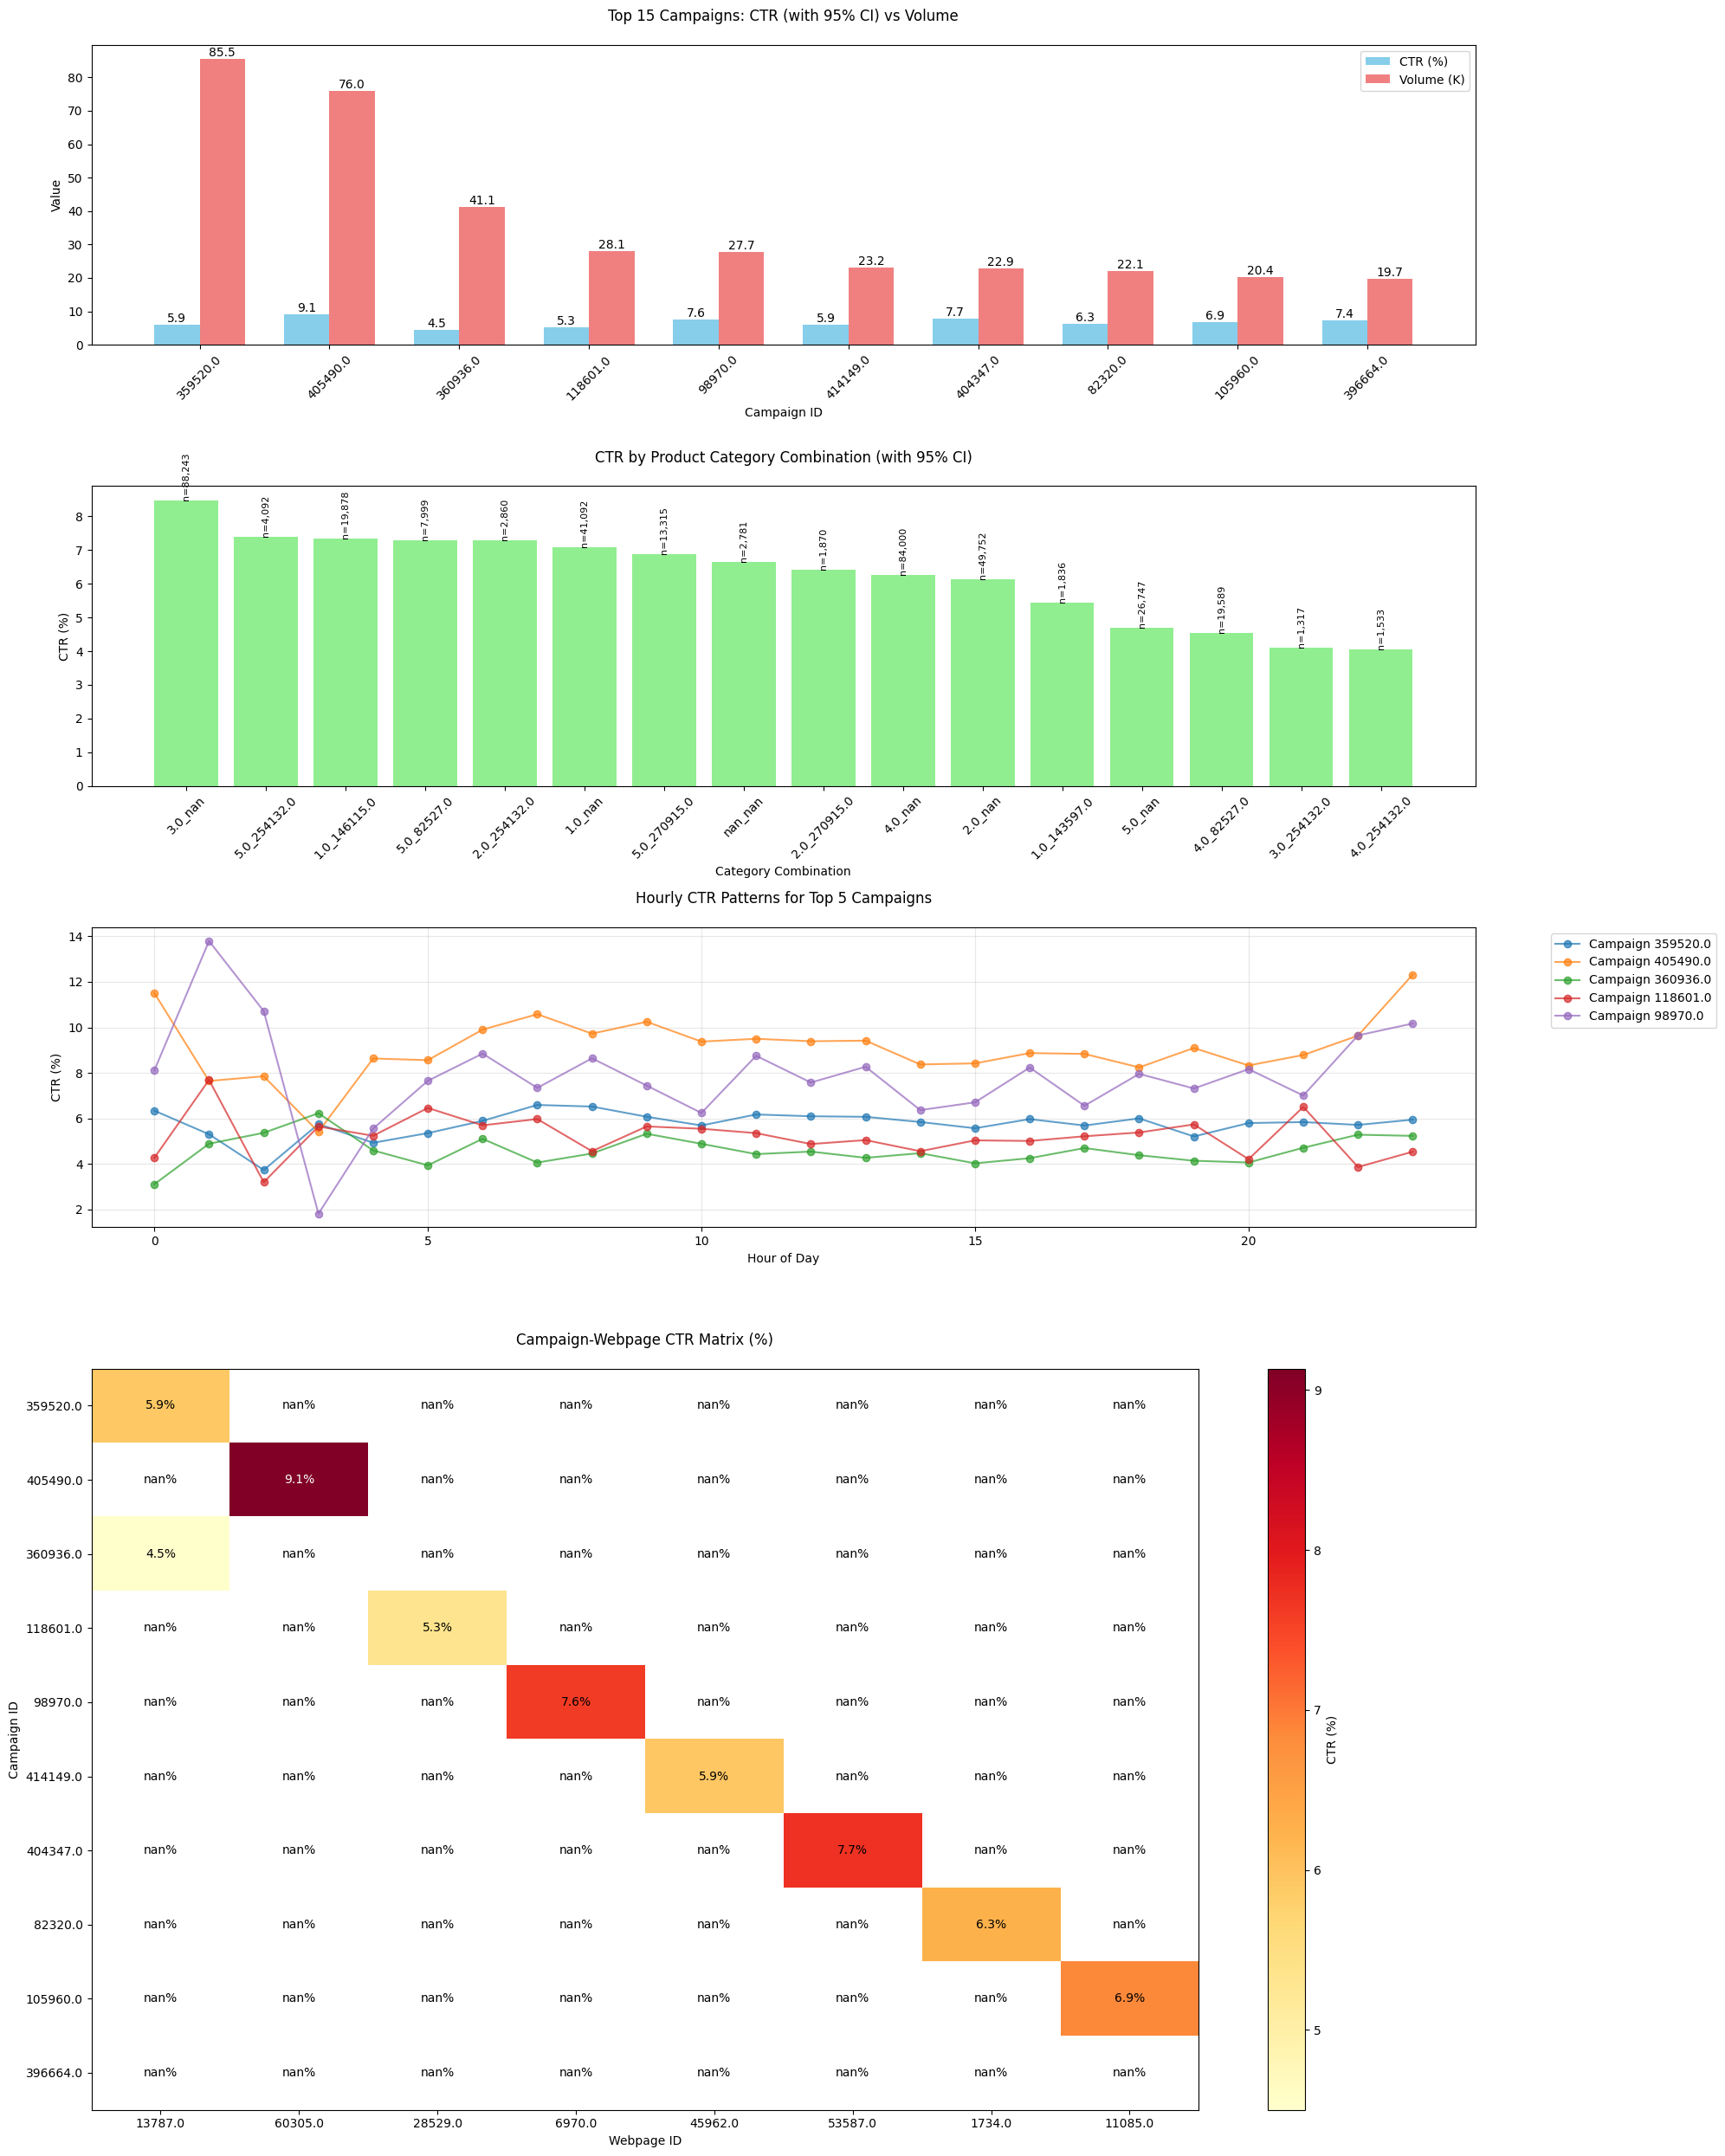


Key Campaign Performance Metrics:
                                        Metric             Value
                      Average Campaign CTR (%)             6.66%
                    CTR Standard Deviation (%)             1.35%
 Number of High-Performing Campaigns (>7% CTR)                 4
Most Consistent Campaign (Lowest CTR Variance) Campaign 360936.0
 Most Variable Campaign (Highest CTR Variance) Campaign 405490.0


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Set up the main figure - adjust grid spacing
fig = plt.figure(figsize=(20, 25))
gs = plt.GridSpec(5, 2, figure=fig)

# 1. Campaign Performance Overview
ax1 = fig.add_subplot(gs[0, :])
campaign_stats = df.groupby('campaign_id').agg({
    'is_click': [
        ('count', lambda x: len(x)),
        ('mean', 'mean'),
        ('ci', lambda x: stats.sem(x) * 1.96 if len(x) > 1 else 0)  # Handle small samples
    ],
    'session_id': ('nunique', lambda x: x.nunique())
}).sort_values(('is_click', 'count'), ascending=False)

top_campaigns = campaign_stats.head(15)
ctr = top_campaigns[('is_click', 'mean')] * 100
volume = top_campaigns[('is_click', 'count')]
ci = top_campaigns[('is_click', 'ci')] * 100

bar_width = 0.35
x = np.arange(len(top_campaigns))
bars1 = ax1.bar(x - bar_width/2, ctr, bar_width, label='CTR (%)', color='skyblue')
bars2 = ax1.bar(x + bar_width/2, volume/1000, bar_width, label='Volume (K)', color='lightcoral')

# Add confidence intervals where we have sufficient data
mask = ci > 0
ax1.errorbar(x[mask] - bar_width/2, ctr[mask], yerr=ci[mask], fmt='none', color='black', capsize=5)

ax1.set_title('Top 15 Campaigns: CTR (with 95% CI) vs Volume', pad=20)
ax1.set_xlabel('Campaign ID')
ax1.set_ylabel('Value')
ax1.set_xticks(x)
ax1.set_xticklabels(top_campaigns.index, rotation=45)
ax1.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom')

# 2. Category Performance with Statistical Significance
ax2 = fig.add_subplot(gs[1, :])
df['category_full'] = df['product_category_1'].astype(str) + '_' + df['product_category_2'].astype(str)
category_stats = df.groupby('category_full').agg({
    'is_click': [
        ('count', lambda x: len(x)),
        ('mean', 'mean'),
        ('ci', lambda x: stats.sem(x) * 1.96 if len(x) > 1 else 0)
    ]
})

# Filter for statistical significance
min_sample = 1000
significant_categories = category_stats[category_stats[('is_click', 'count')] >= min_sample]
significant_categories = significant_categories.sort_values(('is_click', 'mean'), ascending=False)

ctr = significant_categories[('is_click', 'mean')] * 100
ci = significant_categories[('is_click', 'ci')] * 100
volume = significant_categories[('is_click', 'count')]

bars = ax2.bar(range(len(significant_categories)), ctr, color='lightgreen')
ax2.errorbar(range(len(significant_categories)), ctr, yerr=ci, fmt='none', color='black', capsize=5)

ax2.set_title('CTR by Product Category Combination (with 95% CI)', pad=20)
ax2.set_xlabel('Category Combination')
ax2.set_ylabel('CTR (%)')
ax2.set_xticks(range(len(significant_categories)))
ax2.set_xticklabels(significant_categories.index, rotation=45)

# Add sample size annotations using iloc for positional indexing
for i, bar in enumerate(bars):
    ax2.text(i, bar.get_height(), f'n={volume.iloc[i]:,}',
             ha='center', va='bottom', rotation=90, size=8)

# 3. Campaign Daily Pattern Analysis
ax3 = fig.add_subplot(gs[2, :])
df['hour'] = pd.to_datetime(df['DateTime']).dt.hour  # Fixed column name case
df['is_business_hours'] = df['hour'].between(9, 17).astype(int)

top_campaign_ids = campaign_stats.head(5).index
for campaign_id in top_campaign_ids:
    campaign_data = df[df['campaign_id'] == campaign_id]
    hourly_stats = campaign_data.groupby('hour').agg({
        'is_click': [
            ('mean', 'mean'),
            ('count', lambda x: len(x))
        ]
    })
    hourly_ctr = hourly_stats[('is_click', 'mean')] * 100
    ax3.plot(hourly_stats.index, hourly_ctr,
             marker='o', label=f'Campaign {campaign_id}', alpha=0.7)

ax3.set_title('Hourly CTR Patterns for Top 5 Campaigns', pad=20)
ax3.set_xlabel('Hour of Day')
ax3.set_ylabel('CTR (%)')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.grid(True, alpha=0.3)

# 4. Campaign-Webpage Performance Matrix
ax4 = fig.add_subplot(gs[3:, :])  # Use remaining space
campaign_webpage_ctr = df.pivot_table(
    values='is_click',
    index='campaign_id',
    columns='webpage_id',
    aggfunc='mean',
    observed=True
) * 100

# Filter for top campaigns and webpages
top_campaigns = df['campaign_id'].value_counts().nlargest(10).index
top_webpages = df['webpage_id'].value_counts().nlargest(8).index
campaign_webpage_ctr = campaign_webpage_ctr.loc[top_campaigns, top_webpages]

im = ax4.imshow(campaign_webpage_ctr, aspect='auto', cmap='YlOrRd')
plt.colorbar(im, ax=ax4, label='CTR (%)')

for i in range(len(campaign_webpage_ctr.index)):
    for j in range(len(campaign_webpage_ctr.columns)):
        value = campaign_webpage_ctr.iloc[i, j]
        text_color = 'white' if value > 8 else 'black'
        ax4.text(j, i, f'{value:.1f}%', ha='center', va='center', color=text_color)

ax4.set_xticks(np.arange(len(campaign_webpage_ctr.columns)))
ax4.set_yticks(np.arange(len(campaign_webpage_ctr.index)))
ax4.set_xticklabels(campaign_webpage_ctr.columns)
ax4.set_yticklabels(campaign_webpage_ctr.index)
ax4.set_title('Campaign-Webpage CTR Matrix (%)', pad=20)
ax4.set_xlabel('Webpage ID')
ax4.set_ylabel('Campaign ID')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nKey Campaign Performance Metrics:")
performance_summary = pd.DataFrame({
    'Metric': [
        'Average Campaign CTR (%)',
        'CTR Standard Deviation (%)',
        'Number of High-Performing Campaigns (>7% CTR)',
        'Most Consistent Campaign (Lowest CTR Variance)',
        'Most Variable Campaign (Highest CTR Variance)'
    ],
    'Value': [
        f"{campaign_stats[('is_click', 'mean')].mean() * 100:.2f}%",
        f"{campaign_stats[('is_click', 'mean')].std() * 100:.2f}%",
        f"{(campaign_stats[('is_click', 'mean')] * 100 > 7).sum()}",
        f"Campaign {campaign_stats.index[campaign_stats[('is_click', 'mean')].argmin()]}",
        f"Campaign {campaign_stats.index[campaign_stats[('is_click', 'mean')].argmax()]}"
    ]
})

print(performance_summary.to_string(index=False))

Looking at the above results, we can notice that:
* Campaign Volume vs. Effectiveness:
    * Campaign 405490 stands out in terms of performance, with a 9.1% CTR and high volume (76K impressions).
    * While Campaign 359520 leads in volume (85.5K impressions), its moderate 5.9% CTR suggests potential for optimization.
* Category combinations show a clear performance stratification:
    * Top tier (7.5-8.5% CTR): Categories "3.0_nan" and "5.0_254132.0" lead with high statistical significance.
    * Medium tier (6.5-7.5% CTR): Including "1.0_146115.0" and "5.0_82527.0".
    * Bottom tier (<4.5% CTR): Categories "4.0_254132.0" and "3.0_254132.0" significantly under-perform.
* Temporal Patterns:
    * Early morning hours (0-5) show heightened engagement. For instance, campaign 98970.0 achieves peak CTR (~14%) at hour 1, and most of the campaigns show elevated performance before 6 AM.
    * Business hours (9-17) demonstrate consistent but lower engagement, where the average CTR drops by approximately 2-3 percentage points.
    * Late evening (20-23) shows a recovery in CTR, particularly for campaigns 405490.0 and 359520.0.
* Campaign-Webpage Interactions: The heatmap shows a notably high performance for specific combinations (e.g., Campaign 405490.0 on certain webpages).